In [2]:
!pip install shap

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import colormaps
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

import shap

In [4]:
shap.initjs()

In [5]:
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'

In [6]:
model = joblib.load(os.path.join(cwd, "gbm_surrogate_all.pkl"))

In [7]:
states = pd.read_csv(os.path.join(cwd,'month_analysis', 'surrogate_input2.csv'), header=None, index_col=0)

In [8]:
states.index = pd.to_datetime(states.index)

In [9]:
states.dropna(axis=0, inplace=True)

In [10]:
start_date = '2017-06-17 0:00'
end_date = '2017-06-23 23:00'

mask = (states.index >= start_date) & (states.index <= end_date)

test_indices = np.where(mask)[0]

In [11]:
X = np.array(states.iloc[:,:-1])

In [12]:
y = np.array(states.iloc[:,-1])

In [13]:
explainer = shap.TreeExplainer(model, X)

In [14]:
shap_values = explainer.shap_values(X)

In [15]:
repeated_names = [
    'Non Shiftable Load',
    'Solar Generation',
    'Electricity Pricing',
    'Carbon Intensity',
]

In [16]:
def add_hours(feature: str) -> list:
    return [f'{feature} ({i}h)' for i in range(1,25)]

In [17]:
feature_names = []
for name in repeated_names:
    feature_names.extend(add_hours(name))
feature_names.append('Electrical Storage SoC (0h)')

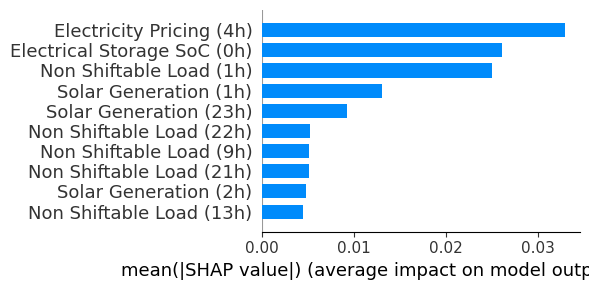

In [18]:
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_size=(6,3), cmap='bwr', plot_type='bar', max_display=10)

In [19]:
display_df = pd.DataFrame(X,columns=feature_names)

In [20]:
shap_df = pd.DataFrame(shap_values,columns=feature_names)

In [21]:
explanations = shap.Explanation(shap_values, explainer.expected_value, data=X, display_data=display_df)

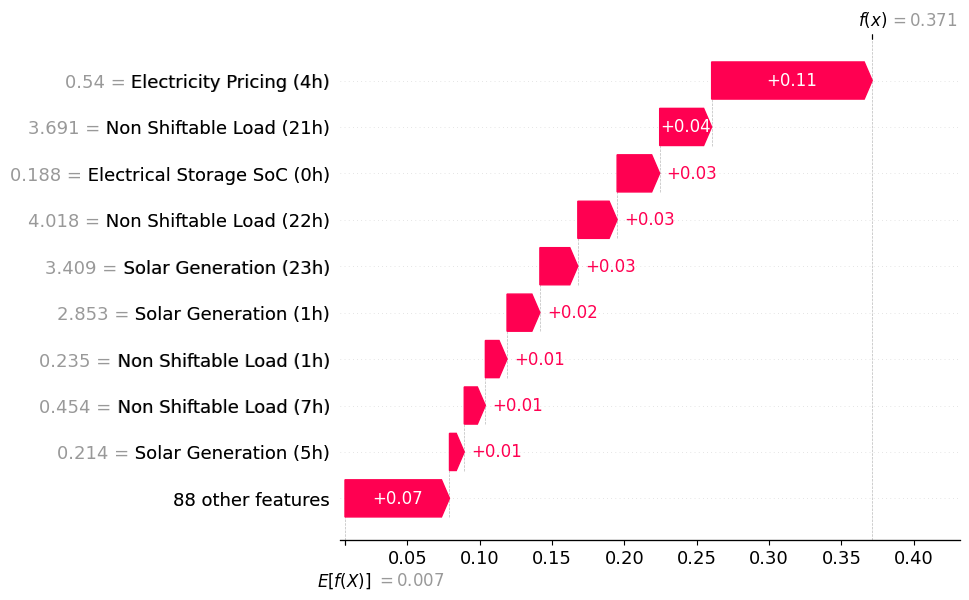

In [22]:
shap.plots.waterfall(explanations[14], max_display=10)

# Timeseries SHAP

In [23]:
cmap = 'bwr'
norm = plt.Normalize(vmin=-0.06, vmax=0.06)

In [24]:
plt.rcParams["font.size"] = 11
legend_loc = (1.08,1)
coord_loc = (-0.06,0.5)
x_range = range(0,len(test_indices))
weekdays = ['                   Sat',
            '                   Sun',
            '                   Mon',
            '                   Tue',
            '                   Wed',
            '                   Thu',
            '                   Fri']

In [25]:
action_list = y[test_indices]
charge = [action_list[0] if action_list[0]>0 else None]
discharge = [action_list[0] if action_list[0]<0 else None]
timestep = [0.0]

for i, a in enumerate(action_list[1:]):
    if a<0 and action_list[i]<0:
        charge.append(None)
        discharge.append(a)
        timestep.append(float(i+1))
    elif a>0 and action_list[i]>0:
        charge.append(a)
        discharge.append(None)
        timestep.append(float(i+1))
    elif a<0 and action_list[i]>0:
        charge.append(0.0)
        charge.append(None)
        discharge.append(0.0)
        discharge.append(a)
        timestep.append(np.interp(0,[-1*action_list[i],-1*a], [i,i+1]))
        timestep.append(float(i+1))
    elif a>0 and action_list[i]<0:
        charge.append(0.0)
        charge.append(a)
        discharge.append(0.0)
        discharge.append(None)
        timestep.append(np.interp(0,[action_list[i],a], [i,i+1]))
        timestep.append(float(i+1))

In [26]:
def baseplot(subplots, size = (20,12)):
    fig = plt.figure(figsize=size)
    gs = fig.add_gridspec(subplots, hspace=0.25)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].set_xticks(np.arange(0, 167, 24))
    axs[0].set_xticklabels(weekdays, ha='left')
    axs[0].plot(range(0,len(action_list)), display_df['Non Shiftable Load (1h)'][test_indices-1], label="Load", color="dimgray")
    axs[0].plot(range(0,len(action_list)), display_df['Solar Generation (1h)'][test_indices-1], label="Generation", color="orange")
    axs[0].set_ylabel('Electrical\nEnergy\n[kWh]')
    axs[0].legend(loc='upper left', bbox_to_anchor=legend_loc, frameon=False)
    axs[0].set_yticks(np.arange(0,6,2.5))
    axs[0].get_yaxis().set_label_coords(*coord_loc)
    axs[1].plot(timestep, charge, color="red", label="Charging",zorder=10)
    axs[1].plot(timestep,discharge, color="blue", label="Discharging",zorder=10)
    axs[1].set_zorder(1)
    axs[1].patch.set_visible(False)
    axs[1].set_ylim((-0.6,0.6))
    axs[1].set_yticks(np.arange(-0.5,1.0,0.5))
    axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[1].set_ylabel('Charge\nRate\n[-]')
    axs[1].get_yaxis().set_label_coords(*coord_loc)
    ax2 = axs[1].twinx()
    ax2.fill_between(range(0,len(action_list)),np.zeros(action_list.shape),display_df['Electrical Storage SoC (0h)'][test_indices], color="green", alpha=0.2, zorder=0, label="SoC")
    ax2.set_ylim((-0.1,1.1))
    ax2.set_yticks([0,0.5,1])
    ax2.set_ylabel('Battery\nSoC')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[1].legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=legend_loc, frameon=False)
    return fig, axs

In [27]:
def shap_scatter(feature, label, shap_idx, plot_idx, ax):
    ax[plot_idx].scatter(x_range, display_df[feature][test_indices], c=shap_values[:,shap_idx][test_indices], cmap=cmap, norm=norm)
    ax[plot_idx].plot(x_range, display_df[feature][test_indices], c='gray', linestyle=":")
    ax[plot_idx].set_ylabel(label)
    ax[plot_idx].get_yaxis().set_label_coords(*coord_loc)

In [28]:
def shap_colorbar(fig, axs, left=0.95, width=0.01, scale=2):
    height = (axs[2].get_position().y1-axs[2].get_position().y0)*scale
    mid = (axs[2].get_position().y1 + axs[-1].get_position().y0)/2
    bottom = mid - height/2
    cbar_ax = fig.add_axes([left, bottom, width, height])
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cbar_ax)
    label_range = np.linspace(norm.vmin, norm.vmax, 5)
    labels = ["{:.2f} Discharging","{:.2f}", " {:.2f}", " {:.2f}"," {:.2f} Charging"]
    cb.ax.set_yticks(label_range)
    cb.ax.set_yticklabels([l.format(r) for l,r in zip(labels, label_range)])
    cb.set_label("SHAP values", labelpad=-130)
    return cb

In [29]:
load_index = [feature_names.index(i) for i in feature_names if "Non Shiftable Load" in i]
gen_index = [feature_names.index(i) for i in feature_names if "Solar Generation" in i]
price_index = [feature_names.index(i) for i in feature_names if "Electricity Pricing" in i]
carbon_index = [feature_names.index(i) for i in feature_names if "Carbon Intensity" in i]

In [30]:
action_map = {}
for i in range(1,25):
    if i >= 6 and i <=14:
        action_map[i] = 0.11
    else:
        action_map[i] = -0.067
rbc_actions = list(action_map.values())*7

In [31]:
def shap_single_plot(idx, size=(5,6)):
    fig = plt.figure(figsize=size)
    gs = fig.add_gridspec(4, hspace=0.25)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].set_xticks(np.arange(0, 25, 6))
    axs[0].scatter(range(24), display_df.iloc[test_indices[idx],load_index], c=shap_df.iloc[test_indices[idx],load_index], cmap=cmap, norm=norm)
    axs[0].plot(range(24), display_df.iloc[test_indices[idx],load_index], c='gray', linestyle=":")
    axs[0].set_ylim((-0.17328, 6.43888))
    axs[0].set_yticks(np.arange(0.0,6.0,2.5))
    axs[1].scatter(range(24), display_df.iloc[test_indices[idx],gen_index], c=shap_df.iloc[test_indices[idx],gen_index], cmap=cmap, norm=norm)
    axs[1].plot(range(24), display_df.iloc[test_indices[idx],gen_index], c='gray', linestyle=":")
    axs[1].set_ylim((-0.17328, 4.23888))
    axs[1].set_yticks(np.arange(0.0,5.0,2))
    axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[2].scatter(range(24), display_df.iloc[test_indices[idx],price_index], c=shap_df.iloc[test_indices[idx],price_index], cmap=cmap, norm=norm)
    axs[2].plot(range(24), display_df.iloc[test_indices[idx],price_index], c='gray', linestyle=":")
    axs[2].set_yticks([0.22, 0.40 ,0.54])
    axs[3].scatter(range(24), display_df.iloc[test_indices[idx],carbon_index], c=shap_df.iloc[test_indices[idx],carbon_index], cmap=cmap, norm=norm)
    axs[3].plot(range(24), display_df.iloc[test_indices[idx],carbon_index], c='gray', linestyle=":")

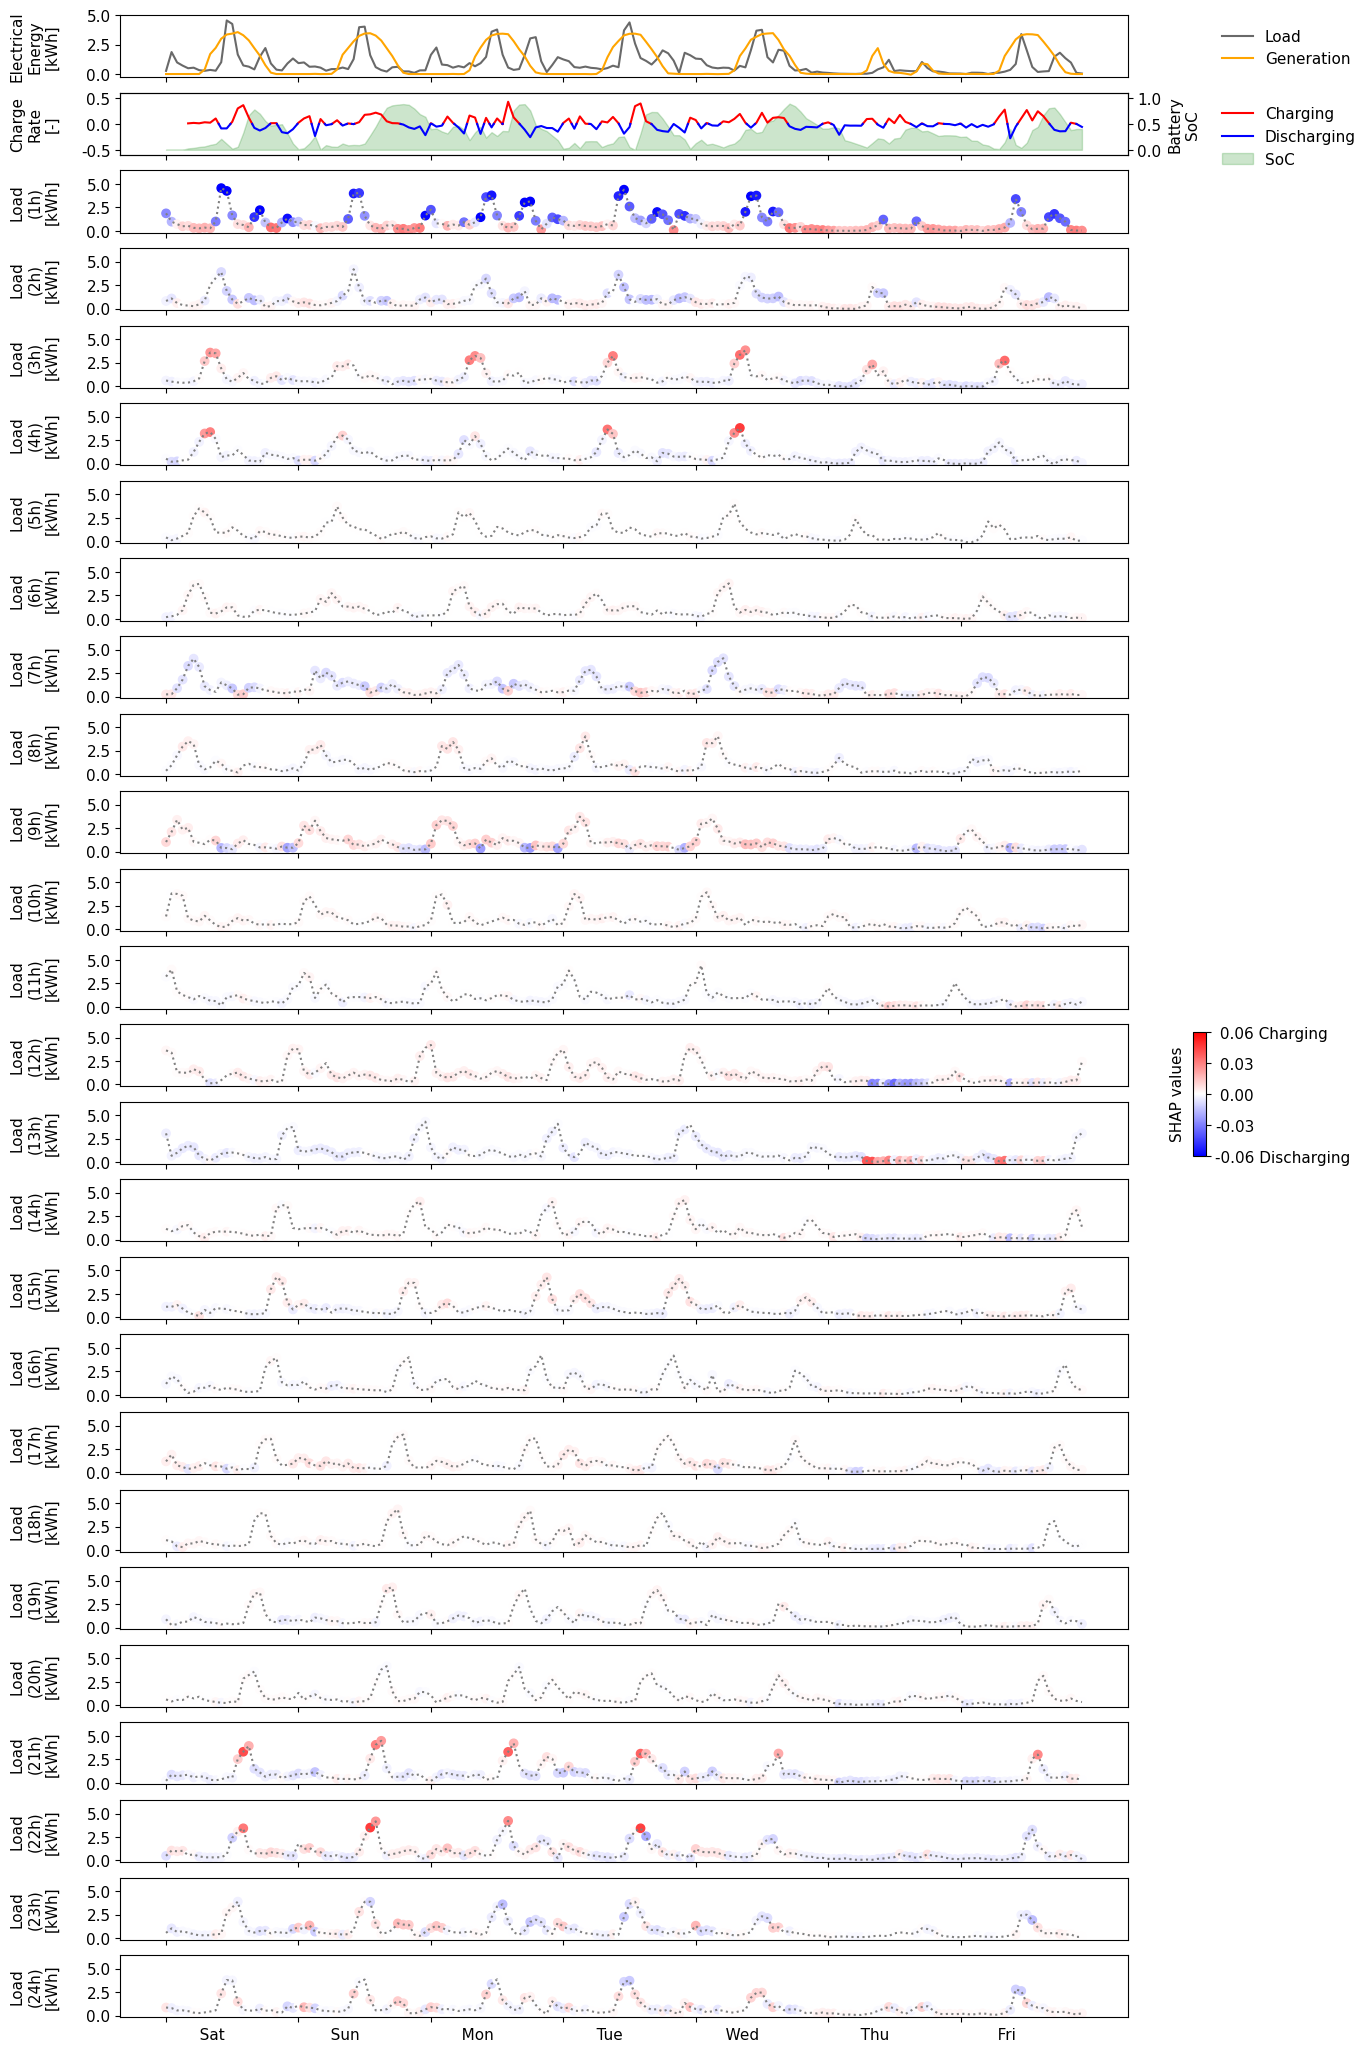

In [32]:
fig, axs = baseplot(26, size=(13,26))
colorbar = shap_colorbar(fig, axs)
for a, i in enumerate(load_index):
    shap_scatter(f'Non Shiftable Load ({a+1}h)', f"Load\n({a+1}h)\n[kWh]", i, a+2, axs)
    axs[a+2].set_ylim((-0.17328, 6.43888))
    axs[a+2].set_yticks(np.arange(0.0,6.0,2.5))

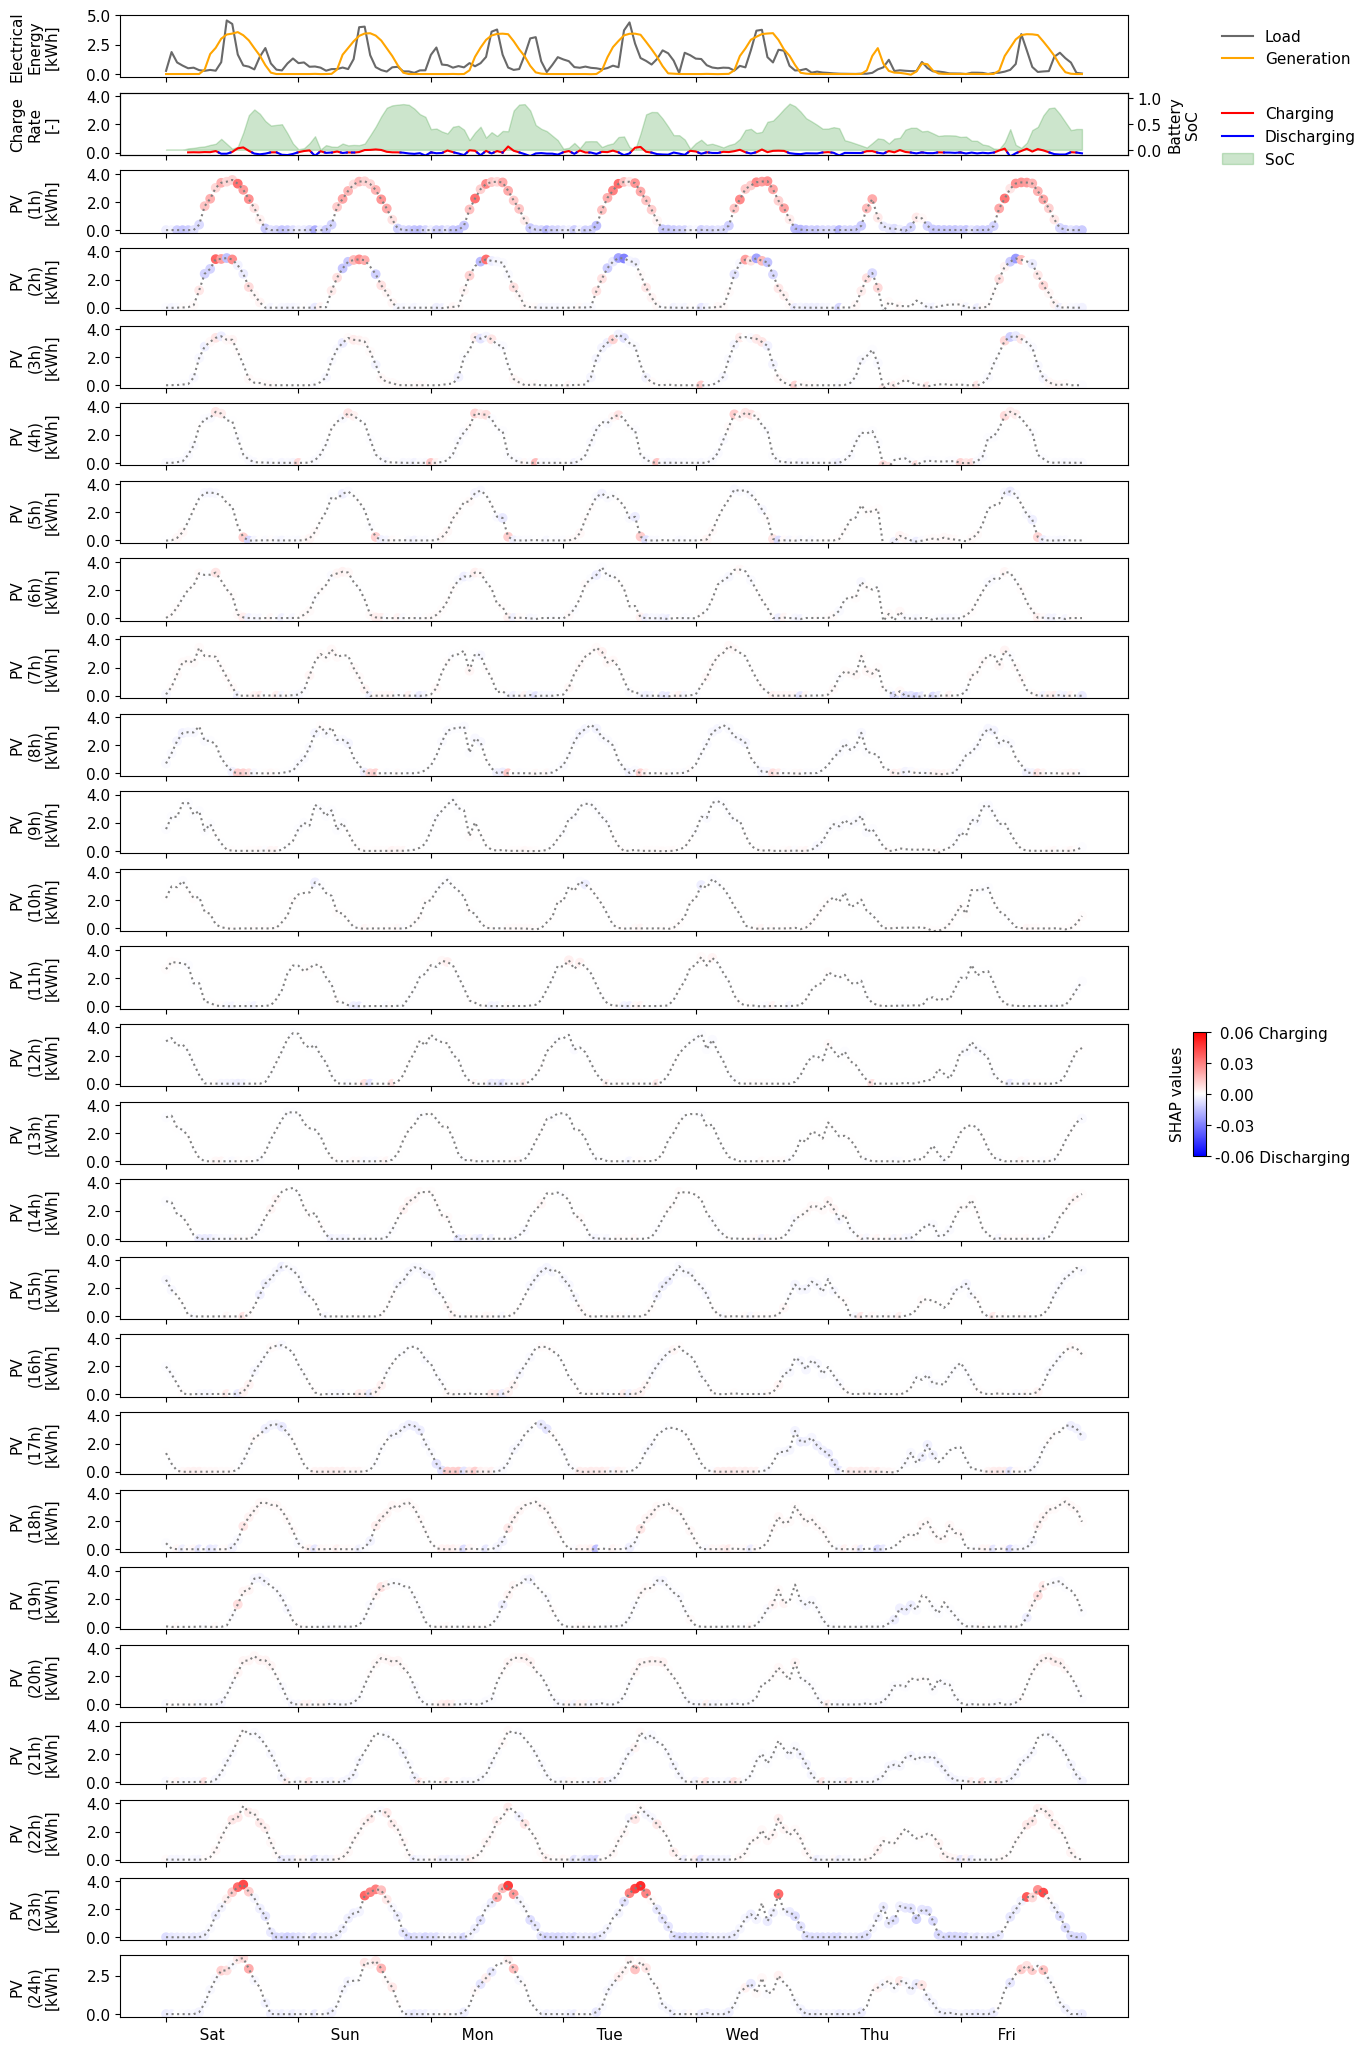

In [33]:
fig, axs = baseplot(26, size=(13,26))
colorbar = shap_colorbar(fig, axs)
for a, i in enumerate(gen_index):
    shap_scatter(f'Solar Generation ({a+1}h)', f"PV\n({a+1}h)\n[kWh]", i, a+2, axs)
    axs[a+1].set_ylim((-0.17328, 4.23888))
    axs[a+1].set_yticks(np.arange(0.0,5.0,2))
    axs[a+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

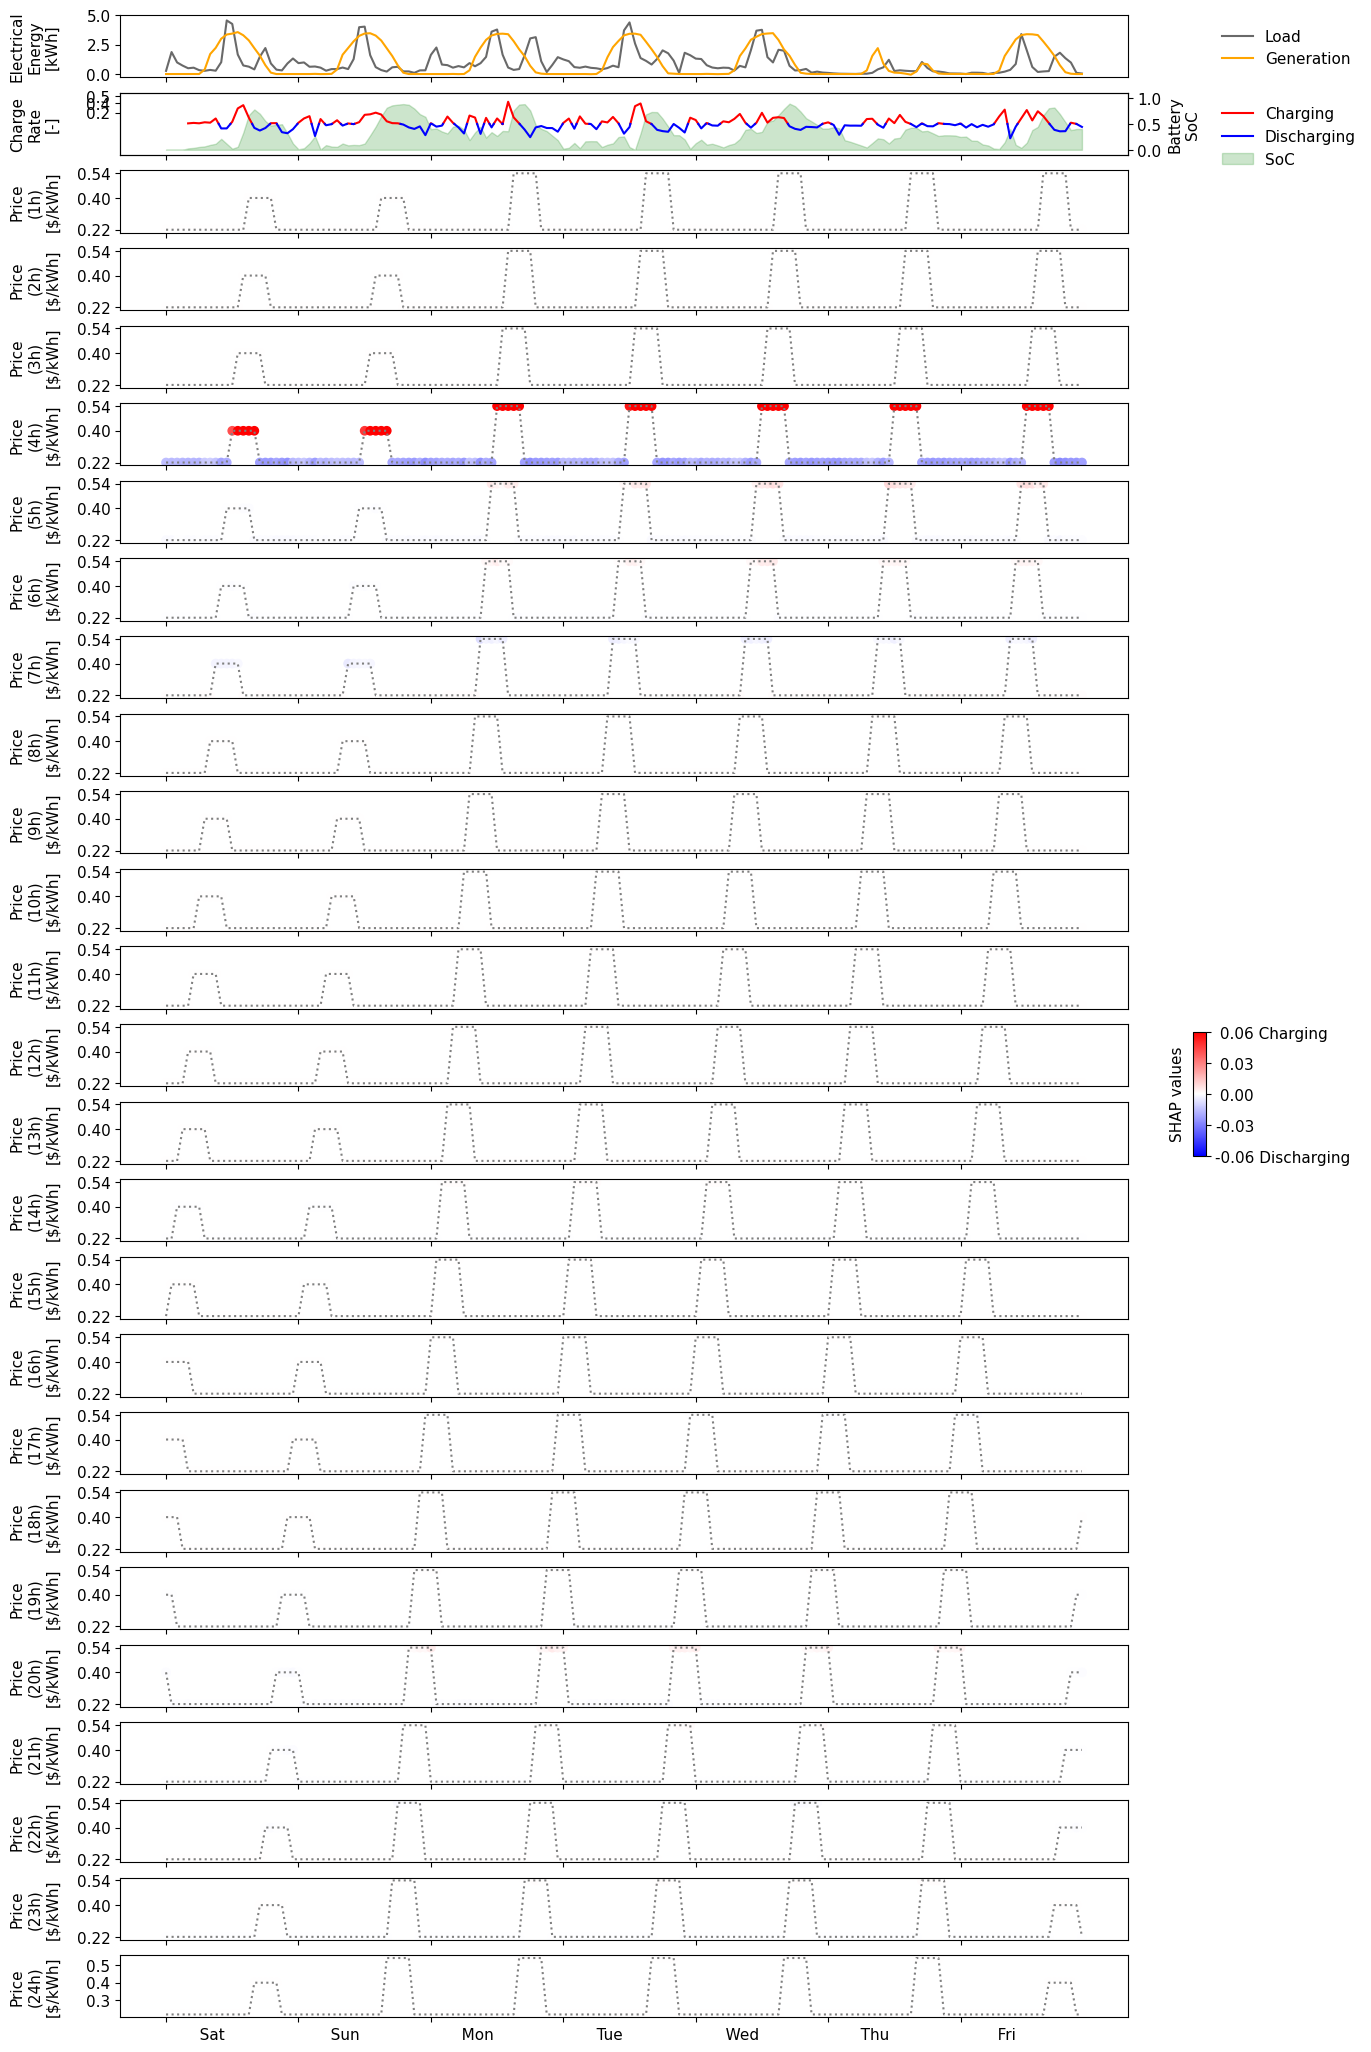

In [34]:
fig, axs = baseplot(26, size=(13,26))
colorbar = shap_colorbar(fig, axs)
for a, i in enumerate(price_index):
    shap_scatter(f'Electricity Pricing ({a+1}h)', f"Price\n({a+1}h)\n[$/kWh]", i, a+2, axs)
    axs[a+1].set_yticks([0.22, 0.40 ,0.54])

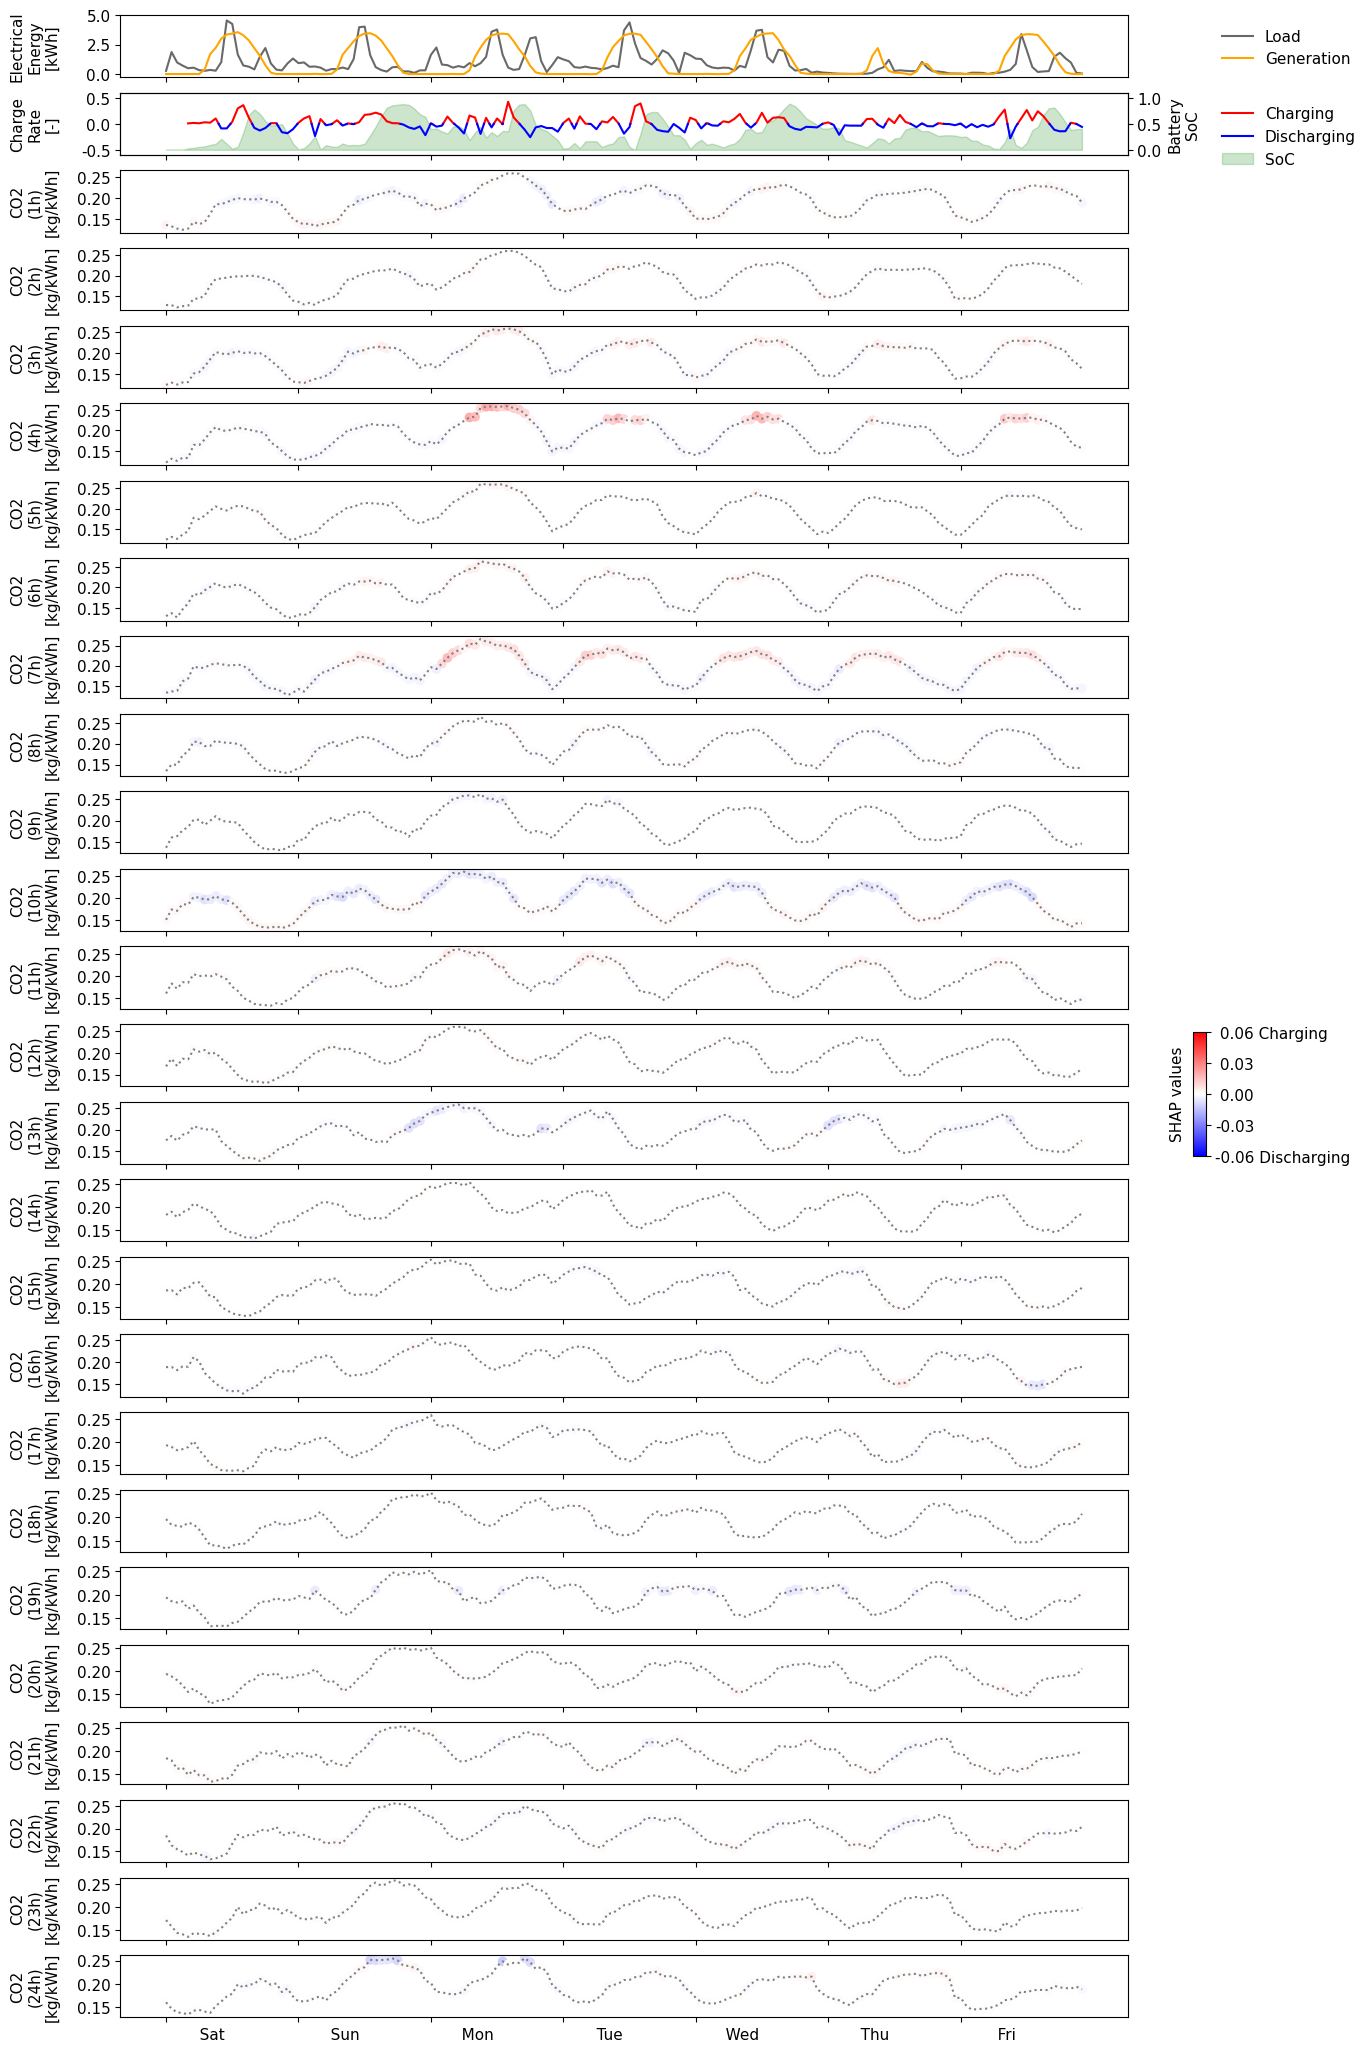

In [35]:
fig, axs = baseplot(26, size=(13,26))
colorbar = shap_colorbar(fig, axs)
for a, i in enumerate(carbon_index):
    shap_scatter(f'Carbon Intensity ({a+1}h)', f"CO2\n({a+1}h)\n[kg/kWh]", i, a+2, axs)

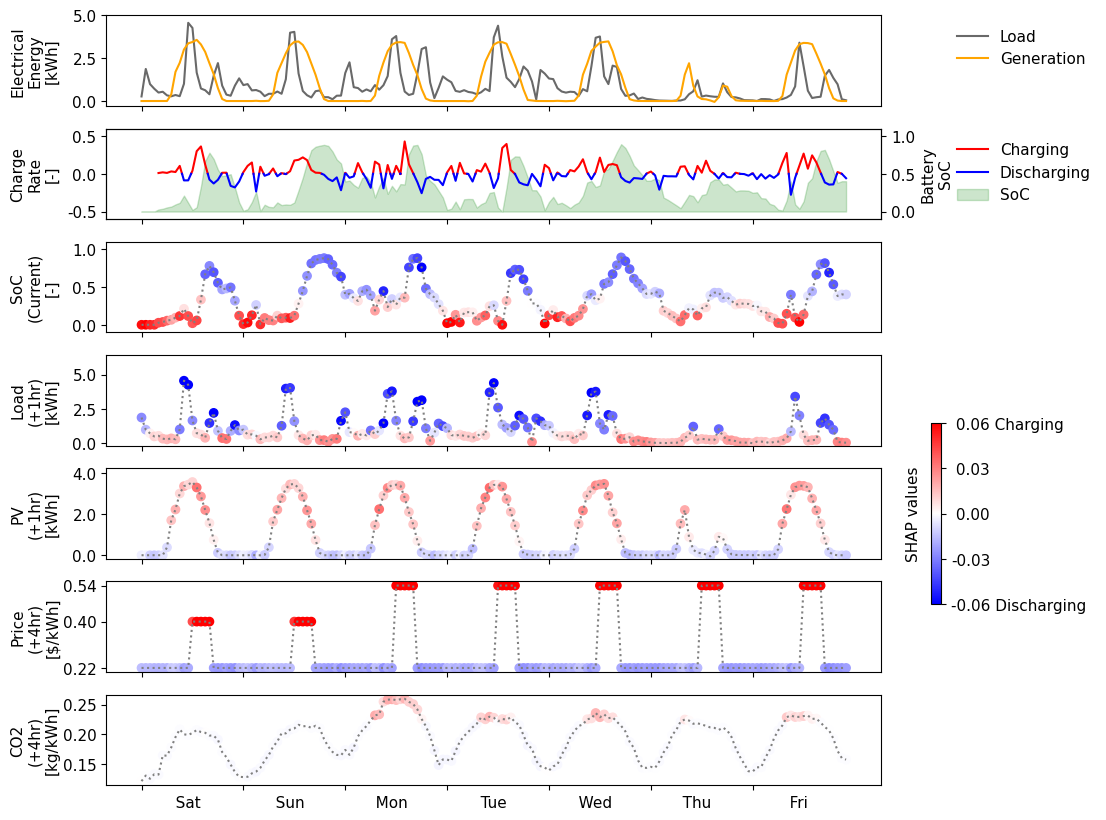

In [36]:
fig, axs = baseplot(7, size=(10,10))
colorbar = shap_colorbar(fig, axs)
shap_scatter(f'Electrical Storage SoC ({0}h)', f"SoC\n(Current)\n[-]", 96, 2, axs)
axs[2].set_ylim((-0.1,1.1))
axs[2].set_yticks([0,0.5,1])
shap_scatter(f'Non Shiftable Load ({1}h)', f"Load\n(+{1}hr)\n[kWh]", 0, 3, axs)
axs[3].set_ylim((-0.17328, 6.43888))
axs[3].set_yticks(np.arange(0.0,6.0,2.5))
shap_scatter(f'Solar Generation ({1}h)', f"PV\n(+{1}hr)\n[kWh]", 24, 4, axs)
axs[4].set_ylim((-0.17328, 4.23888))
axs[4].set_yticks(np.arange(0.0,5.0,2))
axs[4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
shap_scatter(f'Electricity Pricing ({4}h)', f"Price\n(+{4}hr)\n[$/kWh]", 51, 5, axs)
axs[5].set_yticks([0.22, 0.40 ,0.54])
shap_scatter(f'Carbon Intensity ({4}h)', f"CO2\n(+{4}hr)\n[kg/kWh]", 75, 6, axs)

# plt.savefig('shap_scatter.png', dpi=600, format="png", bbox_inches='tight')
plt.savefig("shap_scatter.svg", dpi=300, format="svg", bbox_inches='tight')

In [37]:
future_states = np.array(shap_df.iloc[:,:96])
future_states = future_states.reshape(-1,4,24)

In [38]:
current_states = np.array(shap_df.iloc[:,96])
current_states = current_states.reshape(-1,1)

In [39]:
avg_shap = np.mean(np.abs(future_states),axis=(0))
std_shap = np.std(np.abs(future_states),axis=(0))
upper_shap = avg_shap + std_shap
lower_shap = np.clip(avg_shap - std_shap,0,None)

In [40]:
avg_current = np.full(3, np.mean(np.abs(current_states),axis=(0)))
std_current = np.full(3, np.std(np.abs(current_states),axis=(0)))
upper_current = avg_current + std_current
lower_current = np.clip(avg_current - std_current,0,None)

In [41]:
avg_current

array([0.02607562, 0.02607562, 0.02607562])

In [42]:
colors=['dimgray', 'orange', 'green', 'black']

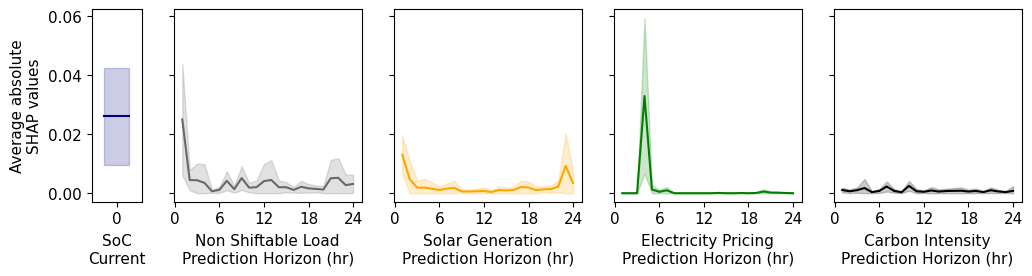

In [49]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,2.5), width_ratios=[0.8,3,3,3,3])

[axs[i].plot(range(1,25), avg_shap[i-1], label=repeated_names[i-1], c=colors[i-1]) for i in range(1,5)]
[axs[i].fill_between(range(1,25), upper_shap[i-1], lower_shap[i-1], color=colors[i-1], alpha=0.2) for i in range(1,5)]
[axs[i].set_xticks(np.arange(0, 25, 6)) for i in range(1,5)]
axs[0].set_ylabel("Average absolute\nSHAP values")
[axs[i].set_xlabel(f"{repeated_names[i-1]}\nPrediction Horizon (hr)", labelpad=5) for i in range(1,5)];

axs[0].plot(range(-1,2,1), avg_current, c='navy')
axs[0].fill_between(range(-1,2,1), upper_current, lower_current, color='navy', alpha=0.2)
axs[0].set_xticks([0])
axs[0].set_xlim(-2,2)
axs[0].set_xlabel("SoC\nCurrent", labelpad=5)

# plt.savefig('avgSHAP.png', dpi=600, format="png", bbox_inches='tight')
plt.savefig("avgSHAP.svg", dpi=300, format="svg", bbox_inches='tight')

In [44]:
np.arange(-.5,1.0,0.5)

array([-0.5,  0. ,  0.5])

In [45]:
soc = np.array(shap_df.iloc[:,96])

In [46]:
np.mean(np.abs(soc))

0.026075621964655307

In [47]:
np.std(np.abs(soc))

0.01647813008982204